<div align="center"><p style="font-family: 'Mochiy Pop P One';font-size:32px; font-weight: bold; color:teal" id="top">Equity Market Crisis Regime Prediction using Machine Learning GBDT</p></div>

<div align="center"><p style="font-family: 'Mochiy Pop P One';font-size:28px; font-weight: bold; color:teal">Part VI: SVM and Neural Networks (MLP and 1D-CNN): 1D-CNN</p>


    
<p style="font-family: 'Mochiy Pop P One';font-size:20px;  font-weight: bold; color:mediumblue; ">
This notebook is the part 6 of a 8-piece series. This part explores other machine learning algorithms to understand their performances compared to the Gradient Boosting Machine Trees such as LightGBM and XGBoost.
<br>
<br> 
Here is the quick access to the whole series.   
</p> 
<br>

</div>

<div align="left" style="font-family: 'Mochiy Pop P One';font-size:16px; font-weight: bold; padding:10px; background:#fafafa; margin-left:2px">
    
<ol>     
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt1">Part I: Introduction</a></li>
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt2">Part II: Data Preparation</a>  </li>
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt3">Part III: Exploratory data analysis</a>  </li> 
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt4">Part IV: Feature Selection, Hyperparameter Tuning (LightGBM)</a>  </li>     
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt5">Part V: Model Evaluation and Interpretation (LightGBM)</a>  </li>    
<li>Part VI: SVM and Neural Networks (MLP and 1D-CNN) <a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6">SVM</a> | <a href="https://www.kaggle.com/code/xxxxyyyy80008/predict-equity-market-crisis-regime-using-gbdt6-2">MLP</a> |<a href="https://www.kaggle.com/code/xxxxyyyy80008/predict-equity-market-crisis-regime-using-gbdt6-3">1D-CNN</a>   </li>      
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt7">Part VII: Compare GBDT Models: XGBoost and LightGBM</a>  </li>     
<li><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt8">Part VIII: Deployment of LightGBM Models (end-to-end process)</a>  </li>
<li><mark><a href="https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes">Predict Stock Market Crashes</a></mark>  </li>
</ol>        
    
</div>



<p style="font-family: 'Mochiy Pop P One';font-size:14px;  font-weight: bold; color:forestgreen; font-style:italic" id="toc">Quick Navigation Of This Notebook: </p>
<div align="left" style="font-family: 'Mochiy Pop P One';font-size:13px; font-weight: bold; color: teal">
<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#0 stype="color: teal">0. Install and Load Packages</a> </span>
<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#1 stype="color: teal">1. Load Data</a> </span>
<span style="padding:10px;background:wheat;margin-left:2px"><a href="https://www.kaggle.com/code/xxxxyyyy80008/equity-market-crisis-regime-prediction-using-gbdt6" stype="color: teal">2. SVM</a> </span>
<span style="padding:10px;background:wheat;margin-left:2px"><a href="https://www.kaggle.com/code/xxxxyyyy80008/predict-equity-market-crisis-regime-using-gbdt6-3" stype="color: teal">3. Neural Networks: MLP (Multilayer perceptron)</a> </span>
<span style="padding:10px;background:wheat;margin-left:2px"><a href=#4 stype="color: teal">4. Neural Networks:1D-CNN</a> </span>
    
<br>
<br>
    
</div>


[4. Neural Networks: 1D-CNN](#4)

- [4.1 Define 1D-CNN and Data Loader class](#4.1)
- [4.2 Train models](#4.2)
- [4.3 Predict testing data](#4.3)
- [4.4 Model performance](#4.4)



<p style="font-family: 'Mochiy Pop P One';font-size:20px;  font-weight: bold; color:teal" id="0">0. Load and install packages <span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span> </p>



In [1]:
import pandas as pd
import numpy as np
import os
import gc
import copy
import json
from pathlib import Path
from datetime import datetime, timedelta, date
import time
from dateutil.relativedelta import relativedelta 


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import statsmodels.api as sm
import seaborn as sns


import pyarrow.parquet as pq
import pyarrow as pa

from tqdm import tqdm


from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
random_seed=1
pl.seed_everything(random_seed)

1


<p style="font-family: 'Mochiy Pop P One';font-size:20px;  font-weight: bold; color:teal" id="1">1. Load data <span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span> </p>



In [3]:
df = pd.read_parquet('../input/equity-market-crisis-regime-prediction-using-gbdt2/data.parquet')
df.set_index(keys=['x_date'], inplace=True)

In [4]:
target_cols = ['pct_chg15', 'regime_change', 'target']
feats = set(df.columns)-set(target_cols)

In [5]:
#final_feats = ['T1YFF_pct_chg60', 'LRUN64TTJPM156S_pct_chg250', 'AAA10Y_chg10', 'T10Y2Y_pct_chg10', 'STOXX50E_chg10', 'BAMLHE00EHYITRIV_pct_chg10', 'T10YFFM_pct_chg10', 'STLFSI3_chg10', 'VIX_chg10', 'JPY=X_pct_chg10', 'IRLTLT01JPM156N_ma_dist20_50', 'NASDAQ100_zscore60', 'KS11_pct_chg10', 'CL=F_pct_chg10', 'T1YFF_pct_chg10', 'CFNAIMA3_ma_dist20_50', 'BAAFFM_zscore60', 'T10Y2YM_zscore250', 'DJI_ma_dist20_50', 'NFCI_zscore60', 'WILLREITIND_zscore60', 'NIKKEI225_zscore60', 'TENEXPCHAREARISPRE_chg250', 'JTSOSL_zscore60', 'CPFF_pct_chg250', 'VIX_pct_chg60', 'COMPOUT_ma_dist20_50', 'STLFSI3_pct_chg10', 'IXIC_ma_dist20_50', 'WILLREITIND_chg10', 'KLSE_zscore60', 'VXDCLS_chg250', 'STLFSI3_zscore250', 'RUT_zscore60', 'LRUN64TTJPM156S_ma_dist20_50', 'UMCSENT_zscore60', 'TENEXPCHAREARISPRE_zscore60', 'GC=F_zscore60', 'JTSOSL_ma_dist20_50', 'RVXCLS_chg10', 'VIXCLS_zscore60', 'NFCIRISK_zscore60', 'T5YIE_pct_chg10', 'AAAFF_pct_chg10', 'T10YFF_pct_chg60', 'ANFCI_pct_chg10', 'ABCOMP_ma_dist20_50', 'IRLTLT01JPM156N_ma_dist200_50', 'VXNCLS_chg10', 'T1YFF_chg10', 'T10Y2Y_chg10', 'NFCIRISK_pct_chg60', 'MANMM101JPM189S_zscore60', 'STLPPMDEF_zscore60', 'CPFF_pct_chg60', 'STLPPM_ma_dist20_50', 'NFCICREDIT_pct_chg10', 'RBJPBIS_chg10', 'JTSOSL_zscore250', 'NFCICREDIT_chg10', 'IRSTCI01JPM156N_zscore60', 'KS11_pct_chg60', 'CFNAI_zscore60', 'T10YIEM_chg60', 'ANFCI_zscore60', 'MYAGM2JPM189S_ma_dist200_50', 'T10Y2YM_pct_chg250', 'KLSE_ma_dist20_50', 'CFNAIDIFF_ma_dist20_50', 'BAMLHYH0A3CMTRIV_pct_chg10', 'KS11_ma_dist20_50', 'BAMLCC0A1AAATRIV_zscore60', 'GC=F_pct_chg10', 'VXNCLS_zscore250', 'STLFSI3_pct_chg60', 'T10YIEM_pct_chg60', 'N100_zscore250', 'TYX_ma_dist200_50', 'NFCI_pct_chg10', 'NASDAQCOM_pct_chg10', 'PAYNSA_chg60', 'IRX_chg10', 'CFNAI_ma_dist20_50', 'CL=F_zscore60', 'BAAFFM_ma_dist200_50', 'T3MFF_zscore60', 'MICH_ma_dist20_50', 'STLFSI3_zscore60', 'GC=F_chg10', 'WILLREITIND_ma_dist20_50', 'NFCICREDIT_pct_chg60', 'KLSE_pct_chg10', 'PAYNSA_ma_dist20_50', 'RBJPBIS_zscore60', 'HSI_chg10', 'AAAFF_chg10', 'STLPPMDEF_chg250', 'FVX_pct_chg10', 'FTSE_chg10', 'N225_chg10', 'BAMLHYH0A0HYM2TRIV_chg10', 'JPNASSETS_zscore60', 'JPNCPIALLMINMEI_pct_chg10', 'CPFF_pct_chg10', 'VIX_zscore60', 'BAA10YM_zscore250', 'ABCOMP_zscore60', 'T10Y3M_pct_chg250', 'PAYEMS_zscore250', 'T10Y2YM_chg250', 'NFCILEVERAGE_chg10', 'NFCINONFINLEVERAGE_zscore60', 'HSI_zscore60', 'VXDCLS_pct_chg10', 'JPNCPIALLMINMEI_zscore60', 'DJI_pct_chg10', 'T3MFF_chg10', 'WILLLRGCAPGR_chg10', 'MYAGM2JPM189S_zscore60', 'FVX_ma_dist20_50', 'VXNCLS', 'NFCICREDIT', 'NFCIRISK_chg10', 'FTSE_zscore60']
#final_feats = ['BAAFFM_ma_dist200_50', 'HSI_chg20', 'PAYEMS_chg60', 'RBJPBIS_ma_dist20_50', 'WILLSMLCAP_chg20', 'BAMLHE00EHYITRIV_pct_chg5', 'WILLREITIND_pct_chg20', 'EXPINF1YR_chg5_above200dMA', 'GVZCLS_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'AAA10Y_pct_chg5', 'N225_pct_chg20', 'RUT_chg10', 'BAAFFM_zscore250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'OVXCLS_volat60', 'PAYNSA_std60', 'GC=F_pct_chg10', 'T10Y2Y_pct_chg120', 'KCFSI_chg20', 'CPFF_chg5', 'T10YIEM_chg60', 'CPFF_pct_chg10', 'HSI_chg5', 'FVX_pct_chg10', 'KS11_pct_chg5', 'NIKKEI225_std60_chg200', 'IRSTCI01JPM156N_chg20', 'DX-Y.NYB_zscore60', 'BAMLHYH0A3CMTRIV_chg10', 'WILLLRGCAPVAL_zscore60', 'N100_std60_chg200', 'TNX_chg20', 'T5YFF_chg10', 'GC=F_chg20', 'VXDCLS_pct_chg20', 'LFWA64TTJPM647S_chg60', 'ABCOMP_pct_chg5', 'HSI_zscore60', 'MYAGM2JPM189S_zscore120', 'USSLIND_pct_chg20', 'T10YFFM_zscore60', 'VXNCLS_chg5', 'STLFSI3_pct_chg60', 'NIKKEI225_zscore120', 'GC=F_chg10', 'STLPPM_chg5', 'VXDCLS_chg5', 'T10Y3M_pct_chg250', 'BAA10Y_zscore250', 'FTSE_chg120', 'NASDAQCOM_zscore60', 'NFCI_pct_chg10', 'ABCOMP_chg5', 'NFCICREDIT_pct_chg5', 'VIX_zscore60', 'VXNCLS_pct_chg10', 'NDX_std125', 'T3MFF_chg10', 'FVX_zscore200', 'WILLREITIND_chg20', 'T10YIEM_pct_chg60', 'FVX_pct_chg5', 'STLFSI3_chg5', 'HSI_chg10', 'NDX_pct_chg10', 'FTSE_chg20', 'WILLLRGCAPGR_chg10', 'CPFF_pct_chg20', 'REAINTRATREARAT1MO_ma_dist500_250', 'MYAGM2JPM189S_chg5', 'VIX_chg10', 'FTSE_pct_chg10', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'NFCI_chg5', 'T10Y2YM_chg250', 'FVX_ma_dist20_50', 'N100_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'DJI_zscore120', 'NFCICREDIT_std60', 'DJI_chg10', 'DJI_pct_chg20', 'FTSE_zscore60', 'WILLLRGCAPVAL_pct_chg10', 'N100_zscore200']
final_feats = ['NASDAQ100_std125_chg200', 'MICH_ma_dist20_50', 'STLPPM_ma_dist20_50', 'GC=F_chg5', 'STLFSI3_pct_chg5', 'VIXCLS_chg20', 'VIX_zscore250', 'IRLTLT01JPM156N_std125', 'LFWA64TTJPM647S_volat60', 'WILLLRGCAPVAL_std60_chg200', 'GC=F_pct_chg20_above200dMA', 'PAYNSA_zscore200', 'T1YFF_pct_chg20', 'NIKKEI225_zscore120', 'LRUN64TTJPM156S_std125_chg200', 'T1YFF_ma_dist200_50', 'WILLSMLCAP_chg20', 'HSI_chg5', 'JPNASSETS_zscore120', 'NIKKEI225_std60_chg200', 'HSI_chg20', 'N225_pct_chg20', 'FVX_chg5', 'NASDAQ100_pct_chg10', 'RBJPBIS_ma_dist20_50', 'KS11_pct_chg5', 'WILLSMLCAP_chg10', 'T10Y2Y_pct_chg120', 'JTSOSL_std60_chg200', 'BAMLHYH0A0HYM2TRIV_std125_chg200', 'IRLTLT01JPM156N_std60_chg200', 'TB3SMFFM_zscore200', 'NIKKEI225_pct_chg10', 'RBJPBIS_zscore60', 'WILLREITIND_ma_dist20_50', 'LRUN64TTJPM156S_pct_chg250', 'MICH_pct_chg5', 'TNX_mean_std120', 'BAMLHE00EHYITRIV_chg10', 'VXNCLS_mean_std120', 'MYAGM2JPM189S_std125', 'BAA10YM_zscore120', 'T10Y3M_chg250', 'MYAGM2JPM189S_chg20', 'EXPINF1YR_chg5_above200dMA', 'NFCICREDIT_pct_chg60', 'GC=F_pct_chg10', 'REAINTRATREARAT1YE_pct_chg120', 'NDX_chg120', 'GVZCLS_chg5', 'KCFSI_chg20', 'AAA10Y_pct_chg5', 'TENEXPCHAINFRISPRE_ma_dist20_50', 'T5YIEM_pct_chg20', 'BAMLHE00EHYITRIV_chg5', 'USSLIND_pct_chg120', 'FVX_pct_chg10', 'T10YIEM_chg60', 'WILLREITIND_pct_chg20', 'BAA10Y_pct_chg10', 'T10YFF_chg10', 'LFWA64TTJPM647S_chg60', 'OVXCLS_volat60', 'RUT_pct_chg10', 'VXNCLS_chg10', 'BAA10Y_zscore250', 'NDX_chg10', 'T10Y2YM_zscore250', 'JPNASSETS', 'CPFF_pct_chg10', 'WILLREITIND_chg20', 'TNX_chg20', 'IRSTCI01JPM156N_chg20', 'GC=F_zscore60', 'CPFF_pct_chg250', 'CPFF_chg5', 'BAMLHYH0A3CMTRIV_chg10', 'CPFF_pct_chg5', 'VXNCLS_chg5', 'GC=F_chg20', 'FVX_pct_chg5', 'T10Y2Y_pct_chg250', 'FTSE_chg10', 'N100_std60_chg200', 'HSI_zscore60', 'NFCIRISK_pct_chg60', 'STLFSI3_pct_chg60', 'VIX_pct_chg10', 'RVXCLS_chg10', 'NFCICREDIT_pct_chg5', 'STLPPM_chg5', 'T3MFF_zscore60', 'ABCOMP_chg5', 'T10Y3M_pct_chg250', 'ABCOMP_pct_chg5', 'USSLIND_pct_chg20', 'STLPPM_pct_chg5', 'T3MFF_chg10', 'FVX_zscore200', 'VXDCLS_chg5', 'VIX_zscore60', 'VIX_chg20', 'STOXX50E_pct_chg10', 'DJI_zscore120', 'STLFSI3_chg5', 'NFCICREDIT', 'T10YIEM_pct_chg60', 'NDX_zscore60', 'HSI_chg10', 'AAAFF_pct_chg5', 'FTSE_mean_std120', 'MYAGM2JPM189S_chg5', 'BAMLHE00EHYITRIV_pct_chg250', 'REAINTRATREARAT1MO_ma_dist500_250', 'CPFF_pct_chg20', 'VXDCLS_pct_chg10', 'BAMLHYH0A3CMTRIV_zscore120', 'NFCI_chg5', 'FTSE_chg20', 'FVX_ma_dist20_50', 'T10YFF_pct_chg20', 'NFCILEVERAGE_chg250', 'BAMLHYH0A0HYM2TRIV_pct_chg10', 'T10Y2YM_std125_chg200', 'CFNAIDIFF_std60', 'N100_zscore120', 'DJI_chg10']

print(len(final_feats))


127


In [6]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [7]:
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [8]:
train_start, train_end =  '2002-01-01',  '2019-12-01'
test_sart, test_end = '2020-01-01', '2022-09-10'

In [9]:
train_df = df[(df.index>=train_start) & (df.index<=train_end)]
test_df = df[(df.index>=test_sart) & (df.index<=test_end)]

train_df.shape,  test_df.shape

((4510, 3779), (708, 3779))


<p style="font-family: 'Mochiy Pop P One';font-size:20px;  font-weight: bold; color:teal" id="4">4. 1D-CNN <span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span> </p>



<p style="font-family: 'Mochiy Pop P One';font-size:18px;  font-weight: bold; color:darkblue" id="4.1">4.1 Define 1D-CNN and Data Loader class<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span></p>


In [10]:
import numpy as np
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.nn import CrossEntropyLoss, MSELoss, BCELoss

In [11]:
#https://www.kaggle.com/code/scaomath/g2net-1d-cnn-gem-pool-pytorch-train-inference
#Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
#https://github.com/baosenguo/Kaggle-MoA-2nd-Place-Solution

import torch
from torch import nn
import numpy as np


class CNN1d(nn.Module):
    def __init__(
        self, 
        input_size, #number of input features
        output_size, #output dimension
        hidden_sizes = [4096], #first layer linear output size
        channels = [256, 512, 512], #channel sizes
        dropouts = [0.1, 0.1, 0.1, 0.3, 0.2, 0.2], #dropout rates
        celu_alpha = 0.06, 
    ):
        super().__init__()
        
        #the channel size after reshaping linear output matrix
        #for example, if Linear layer output is 4096 and first 1d CNN input channel is 256, 
        #then the reshape size is 16
        linear_reshape_channel = int(hidden_sizes[0]/channels[0]) 
        avg_pool_output = int(hidden_sizes[0]/channels[0]/2)
        max_pool_output = int(hidden_sizes[0]/channels[0]/2/2)*channels[2]
        
        self.linear_reshape_channel = linear_reshape_channel
        self.channels = channels
        
        #transform n*m (m=input_size) matrix into n*hidden_sizes[0] matrix
        self.linear1 = nn.Sequential(
            nn.BatchNorm1d(input_size),
            nn.Dropout(dropouts[0]),
            nn.utils.weight_norm(nn.Linear(input_size, hidden_sizes[0])),
            nn.CELU(alpha=celu_alpha)
        )
        
        #1st layer of convolutional network
        self.cnn1 = nn.Sequential(
            nn.BatchNorm1d(channels[0]), 
            nn.Dropout(dropouts[1]),
            nn.utils.weight_norm(nn.Conv1d(in_channels = channels[0], 
                                           out_channels = channels[1], 
                                           kernel_size = 5, 
                                           stride=1, 
                                           padding=2, 
                                           bias=False), dim=None),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size = avg_pool_output)

        )
        
        #2nd layer of convolutional network
        self.cnn2 = nn.Sequential(
            nn.BatchNorm1d(channels[1]), 
            nn.Dropout(dropouts[2]),
            nn.utils.weight_norm(nn.Conv1d(in_channels = channels[1], 
                                           out_channels = channels[1], 
                                           kernel_size = 3, 
                                           stride=1, 
                                           padding=1, 
                                           bias=True), dim=None),
            nn.ReLU(),

        )
        
        #3rd layer of convolutional network
        self.cnn3 = nn.Sequential(
            nn.BatchNorm1d(channels[1]), 
            nn.Dropout(dropouts[3]),
            nn.utils.weight_norm(nn.Conv1d(in_channels = channels[1], 
                                           out_channels = channels[1], 
                                           kernel_size = 3, 
                                           stride=1, 
                                           padding=1,  
                                           bias=True), dim=None),
            nn.ReLU(),
            
            nn.BatchNorm1d(channels[1]), 
            nn.Dropout(dropouts[4]),
            nn.utils.weight_norm(nn.Conv1d(in_channels = channels[1], 
                                           out_channels = channels[2], 
                                           kernel_size = 5, 
                                           stride=1, 
                                           padding=2, 
                                           bias=True), dim=None),
            nn.ReLU(),
            
        )
        
        #output layer 
        self.out = nn.Sequential(
            nn.MaxPool1d(kernel_size = 4, stride=2, padding=1),
            nn.Flatten(),
            nn.BatchNorm1d(max_pool_output),
            nn.Dropout(dropouts[5]),
            nn.utils.weight_norm(nn.Linear(max_pool_output, output_size)),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.linear1(x)
        x = x.reshape(x.shape[0],  self.channels[0], self.linear_reshape_channel)
        
        x = self.cnn1(x)
        x_cnn2 = self.cnn2(x)
        
        x = self.cnn3(x)
        x = x_cnn2*x
        
        x = self.out(x)

        return x

In [12]:
import torch
from torch.utils.data import (Dataset, DataLoader)
  

class Train_Data(Dataset):
    
    def __init__(self, X, y): 
        
        features = torch.FloatTensor(X)
        targets = torch.FloatTensor(y)
        
        self.features = features
        self.targets = targets
        
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        

        x = self.features[idx]
        y = self.targets[idx]
        
        return x, y
    

def load_traindata(X, y, batch_size, n_workers=0, shuffle=False):
    data = Train_Data(X, y)
    
    loader = DataLoader(data, batch_size=batch_size, num_workers=n_workers, shuffle=shuffle)
    
    return loader

In [13]:
import torch
from torch.utils.data import (Dataset, DataLoader)
  

class Test_Data(Dataset):
    
    def __init__(self, X): 
        
        features = torch.FloatTensor(X)
        
        self.features = features
        
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        

        x = self.features[idx]
        
        return x
    

def load_testdata(X, batch_size, n_workers=0, shuffle=False):
    data = Test_Data(X)
    
    loader = DataLoader(data, batch_size=batch_size, num_workers=n_workers, shuffle=shuffle)
    
    return loader

In [14]:
loss_dict = []

def train_cnn(params, seed, train_loader, input_size, model_file):
    pl.seed_everything(seed)
    print(params)
    
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    h_sizes = [params['hidden_size1']]
    drop_list = [params[f'dropout{i}'] for i in range(1,7)]
    celu_alpha = params['celu_alpha']
    channels = [params['channel'], 2*params['channel'], 2*params['channel']]




    model = CNN1d(input_size=input_size, 
                  output_size=1, 
                  hidden_sizes = h_sizes, 
                  channels = channels, 
                  dropouts = drop_list, 
                  celu_alpha = celu_alpha)

    model = model.to(device)

    # optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  
    optimizer = torch.optim.RMSprop([
            {'params': model.linear1.parameters()},
            {'params': model.cnn1.parameters()},
            {'params': model.cnn2.parameters()},
            {'params': model.cnn3.parameters()},
            {'params': model.out.parameters()},
        ], lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_loader))
    out_loss = BCELoss()



    #------train models--------------------------
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            ### FORWARD AND BACK PROP
            out = model(features)
            out_cost = out_loss(out.squeeze(), targets) #squeeze the n_samples*1 2d array to 1d array of n_samples

            optimizer.zero_grad()

            out_cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

    #-------save model to a file-----
    torch.save(model.state_dict(), model_file)
    
    
def inference_cnn(params, model_file, input_size, test_loader, seed):
    #-----load model file
    pl.seed_everything(seed)
    
    
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']
    h_sizes = [params['hidden_size1']]
    drop_list = [params[f'dropout{i}'] for i in range(1,7)]
    celu_alpha = params['celu_alpha']
    channels = [params['channel'], 2*params['channel'], 2*params['channel']]

    model = CNN1d(input_size=input_size, 
                  output_size=1, 
                  hidden_sizes = h_sizes, 
                  channels = channels, 
                  dropouts = drop_list, 
                  celu_alpha = celu_alpha)
    
    model.load_state_dict(torch.load(model_file, map_location = torch.device('cpu')))
    model = model.to(device)

    # optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  
    optimizer = torch.optim.RMSprop([
            {'params': model.linear1.parameters()},
            {'params': model.cnn1.parameters()},
            {'params': model.cnn2.parameters()},
            {'params': model.cnn3.parameters()},
            {'params': model.out.parameters()},
        ], lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(train_loader))
    out_loss = BCELoss()

    
    #-----eval models-------------------------------
    model.eval()

    y_preds = []
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)
            outputs = model(features)
            y_preds.extend(outputs.squeeze().cpu().numpy())


    y_preds = np.array(y_preds)
    return y_preds


<p style="font-family: 'Mochiy Pop P One';font-size:18px;  font-weight: bold; color:darkblue" id="4.2">4.2 Train models<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span></p>


In [15]:
X = train_df[final_feats]
y = train_df[['target']]

# X = df[final_feats]
# y = df[['target']]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [17]:
scaler_ = StandardScaler()
scaler_.fit(X)
# minmax_scaler.fit_transform(X_train[x_cols])


StandardScaler()

In [18]:
params_list =[
   {'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'dropout2': 0.406, 'dropout3': 0.423, 'dropout4': 0.144, 'dropout5': 0.463, 'dropout6': 0.265, 'hidden_size1': 512, 'learning_rate': 0.15, 'num_epochs': 35}, 
]
len(params_list)
seeds = [1, 2, 3, 4, 5]

In [19]:
%%time
for i, params in enumerate(params_list):
    batch_size = params['batch_size']
    train_loader = load_traindata(scaler_.transform(X), y['target'].values, 
                         batch_size=batch_size, n_workers=0, shuffle=False)
    for seed in seeds:
        train_cnn(params=params, seed=seed, train_loader=train_loader, input_size=len(final_feats), model_file=f'{i}_cnn_{seed}.pth')


{'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'dropout2': 0.406, 'dropout3': 0.423, 'dropout4': 0.144, 'dropout5': 0.463, 'dropout6': 0.265, 'hidden_size1': 512, 'learning_rate': 0.15, 'num_epochs': 35}
{'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'dropout2': 0.406, 'dropout3': 0.423, 'dropout4': 0.144, 'dropout5': 0.463, 'dropout6': 0.265, 'hidden_size1': 512, 'learning_rate': 0.15, 'num_epochs': 35}
{'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'dropout2': 0.406, 'dropout3': 0.423, 'dropout4': 0.144, 'dropout5': 0.463, 'dropout6': 0.265, 'hidden_size1': 512, 'learning_rate': 0.15, 'num_epochs': 35}
{'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'dropout2': 0.406, 'dropout3': 0.423, 'dropout4': 0.144, 'dropout5': 0.463, 'dropout6': 0.265, 'hidden_size1': 512, 'learning_rate': 0.15, 'num_epochs': 35}
{'batch_size': 128, 'celu_alpha': 0.06, 'channel': 32, 'dropout1': 0.303, 'd



<p style="font-family: 'Mochiy Pop P One';font-size:18px;  font-weight: bold; color:darkblue" id="4.3">4.3 Predict testing data<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span></p>


In [20]:
%%time
all_preds = []

for i, params in enumerate(params_list):
    batch_size = params['batch_size']
    test_loader = load_testdata(scaler_.transform(test_df[final_feats]), batch_size=batch_size, n_workers=0, shuffle=False)
    
    for seed in seeds:
        cnn_preds = inference_cnn(params=params, model_file=f'{i}_cnn_{seed}.pth', input_size=len(final_feats), test_loader=test_loader, seed=seed)
        all_preds.append(cnn_preds)

CPU times: user 312 ms, sys: 4.97 ms, total: 316 ms
Wall time: 161 ms


In [21]:
all_preds[0].shape, test_df.shape

((708,), (708, 3779))

In [22]:
test_df.head(2)

,pct_chg15,regime_change,target,GSPC,DJI,IXIC,RUT,VIX,TYX,TNX,FVX,IRX,NDX,DX-Y.NYB,EEM,IEMG,FTSE,STOXX50E,N225,JPY=X,KS11,GC=F,CL=F,HSI,KLSE,N100,T10Y2Y,T10YIE,T10Y3M,T5YIE,T5YIFR,PAYEMS,UMCSENT,BAA10Y,VIXCLS,MICH,NFCI,T10YFF,NASDAQCOM,AAA10Y,REAINTRATREARAT10Y,WILL5000INDFC,USSLIND,STLFSI3,BAMLHYH0A0HYM2TRIV,REAINTRATREARAT1YE,EXPINF1YR,JPNCPIALLMINMEI,ANFCI,WILL5000PRFC,...,EVZCLS_chg120,EVZCLS_pct_chg120,EVZCLS_chg250,EVZCLS_pct_chg250,EVZCLS_ma_dist20_50,EVZCLS_ma_dist200_50,EVZCLS_ma_dist500_250,EVZCLS_std60,EVZCLS_std60_chg200,EVZCLS_volat60,EVZCLS_std125,EVZCLS_std125_chg200,EVZCLS_volat125,EVZCLS_mean_std120,EVZCLS_mean_std250,EVZCLS_zscore60,EVZCLS_zscore120,EVZCLS_zscore200,EVZCLS_zscore250,IRSTCB01JPM156N_chg5,IRSTCB01JPM156N_pct_chg5,IRSTCB01JPM156N_chg5_above200dMA,IRSTCB01JPM156N_pct_chg5_above200dMA,IRSTCB01JPM156N_chg10,IRSTCB01JPM156N_pct_chg10,IRSTCB01JPM156N_chg20,IRSTCB01JPM156N_pct_chg20,IRSTCB01JPM156N_chg20_above200dMA,IRSTCB01JPM156N_pct_chg20_above200dMA,IRSTCB01JPM156N_chg60,IRSTCB01JPM156N_pct_chg60,IRSTCB01JPM156N_chg120,IRSTCB01JPM156N_pct_chg120,IRSTCB01JPM156N_chg250,IRSTCB01JPM156N_pct_chg250,IRSTCB01JPM156N_ma_dist20_50,IRSTCB01JPM156N_ma_dist200_50,IRSTCB01JPM156N_ma_dist500_250,IRSTCB01JPM156N_std60,IRSTCB01JPM156N_std60_chg200,IRSTCB01JPM156N_volat60,IRSTCB01JPM156N_std125,IRSTCB01JPM156N_std125_chg200,IRSTCB01JPM156N_volat125,IRSTCB01JPM156N_mean_std120,IRSTCB01JPM156N_mean_std250,IRSTCB01JPM156N_zscore60,IRSTCB01JPM156N_zscore120,IRSTCB01JPM156N_zscore200,IRSTCB01JPM156N_zscore250
x_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.04,0.00,0.00,"3,257.85","28,868.80","9,092.19","1,666.77",12.47,2.34,1.88,1.67,1.50,"8,872.22",96.85,43.82,51.57,"7,604.30","3,748.47","23,656.62",108.71,"2,175.17","1,524.50",61.18,"28,543.52","1,602.50","1,158.26",0.32,1.75,0.33,1.66,1.84,"151,589.00",96.80,1.97,14.82,2.50,-0.55,0.37,"8,945.99",1.12,0.51,152.40,1.41,-0.23,"1,411.36",-0.29,1.70,102.21,-0.66,"32,788.76",...,-0.01,-0.00,-2.75,-0.35,-0.27,0.56,0.89,0.52,-0.10,0.36,0.72,-0.06,0.86,-0.00,-0.02,-0.38,-0.87,-0.98,-1.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.00,1.00,-0.06
2020-01-03,0.03,0.00,0.00,"3,234.85","28,634.88","9,020.77","1,660.87",14.02,2.25,1.79,1.59,1.47,"8,793.90",96.84,43.01,50.66,"7,622.40","3,773.37","23,656.62",108.54,"2,176.46","1,549.20",63.05,"28,451.50","1,611.38","1,157.38",0.30,1.80,0.34,1.72,1.88,"151,589.00",96.80,1.98,12.47,2.50,-0.55,0.37,"9,092.19",1.12,0.51,154.07,1.41,-0.23,"1,413.29",-0.29,1.70,102.21,-0.66,"33,142.20",...,-0.04,-0.01,-2.07,-0.28,-0.27,0.57,0.90,0.51,-0.14,0.35,0.72,-0.07,0.86,-0.00,-0.02,-0.26,-0.80,-0.90,-1.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.00,1.00,-0.06


In [23]:
len(all_preds)

5

In [24]:
pred_cols = []
df_pred = test_df[['target']].copy(deep=True)
for i, pred in enumerate(all_preds):
    df_pred[f'pred{i+1}'] = pred
    pred_cols.append(f'pred{i+1}')

<p style="font-family: 'Mochiy Pop P One';font-size:18px;  font-weight: bold; color:darkblue" id="4.4">4.4 Model performance<span style="padding:10px;background:wheat;margin-left:2px"> <a href=#top stype="color: teal">BACK TO TOP</a> </span></p>


<AxesSubplot:xlabel='x_date'>

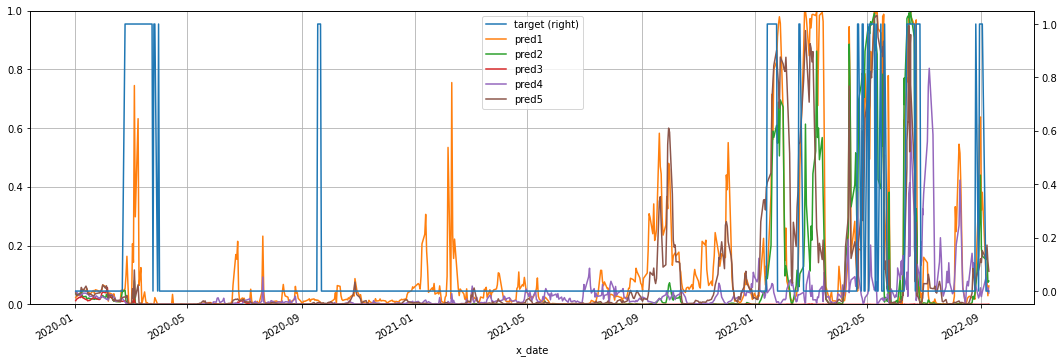

In [25]:
df_pred.plot(figsize=(18, 6), secondary_y=['target'], grid=True, ylim=(0,1))

In [26]:
df_pred['pred_mean'] = df_pred[pred_cols].mean( axis=1)
#df_pred['pred_mean_label']=((df_pred[pred_cols]>0.5).mean(axis=1)>0.5).astype(int)
df_pred['pred_mean_label']=(df_pred['pred_mean']>0.5).astype(int)

<AxesSubplot:xlabel='x_date'>

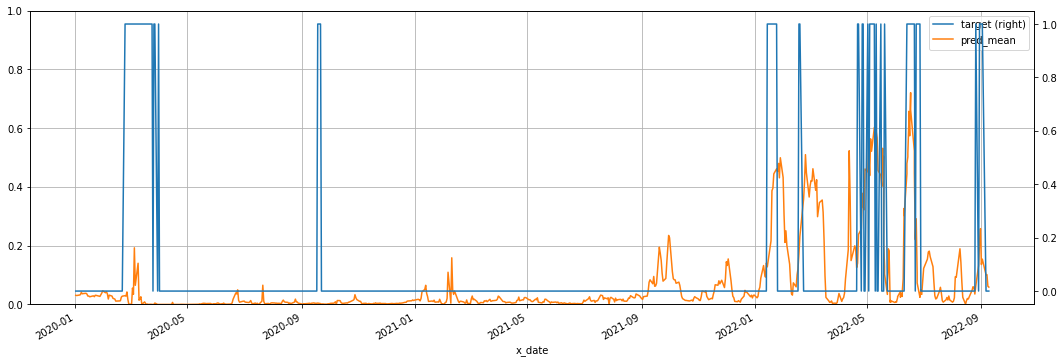

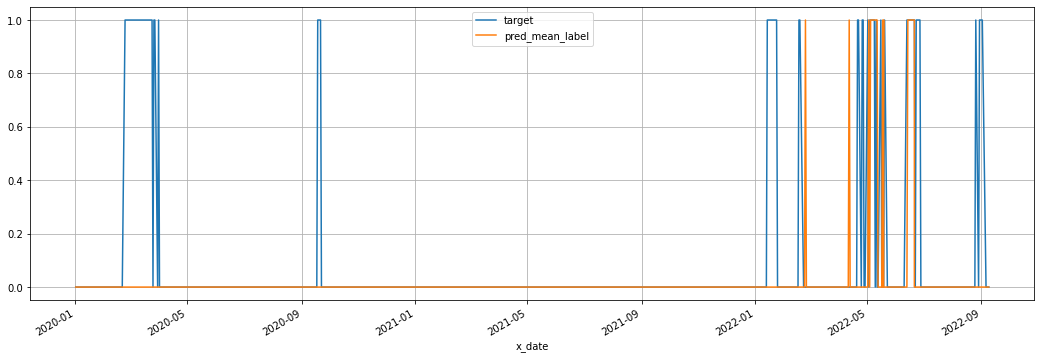

In [27]:
df_pred[['target', 'pred_mean',]].plot(figsize=(18, 6), secondary_y=['target'], grid=True, ylim=(0,1))
df_pred[['target', 'pred_mean_label']].plot(figsize=(18, 6),  grid=True)

In [28]:
for c in pred_cols + ['pred_mean']:
    auc_score = roc_auc_score(df_pred['target'], df_pred[c])
    print(c, f'{auc_score:.3f}')

pred1 0.747
pred2 0.695
pred3 0.471
pred4 0.521
pred5 0.691
pred_mean 0.722


In [29]:
prob_cut = 0.5
tp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==1) ).sum() #true positive 
fp = ((df_pred['pred_mean']>prob_cut) & (df_pred['target']==0) ).sum() #false positive
fn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==1) ).sum() #false negative
tn = ((df_pred['pred_mean']<=prob_cut) & (df_pred['target']==0) ).sum() #true negative

cm = pd.DataFrame(data=[[tp, fp, ], [fn, tn,]], 
                  index=['Predict: Crisis', 'Predict: Normal'], 
                  columns=['Actual: Crisis', 'Actual: Normal', ],
                 )
precision = tp/(tp+fp) 
recall = tp/(tp + fn)
#cm

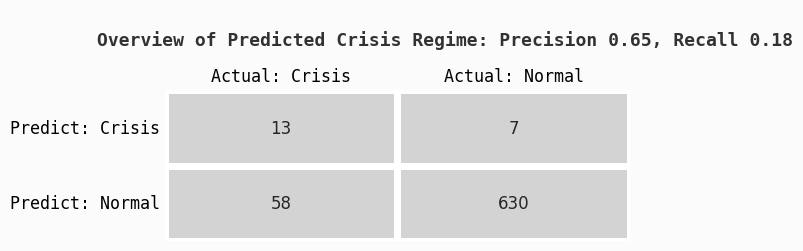

In [30]:
colors = ["lightgray", "lightgray","lightgray",]


background_color = "#fbfbfb"

fig, ax = plt.subplots(1, 1, figsize=(6,2),  dpi=100,facecolor=background_color)


sns.heatmap(cm, cmap=colors,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax,
            yticklabels=cm.index,vmax=500,vmin=0,
            xticklabels=cm.columns,annot_kws={"fontsize":12})
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_facecolor(background_color) 
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontfamily='monospace', fontsize=10)#
#ax.tick_params(axis=u'both', which=u'both',length=0, )
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom = False, bottom=False, top = False, labeltop=True)
fig.text(.012, 1., f'''
Overview of Predicted Crisis Regime: Precision {precision:.2f}, Recall {recall:.2f}
''', fontfamily='monospace',fontweight='bold',fontsize=13,color='#323232', ha='left')


plt.show()